In [1]:
# TODO Test Featuretools
# TODO Test LSTM for Feature Extraction
# Test both weighted and unweighted class approaches for better CV-LB estimation.
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
import re
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix
import featuretools as ft 
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [2]:
'''
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()
'''

'\ndef plot_confusion_matrix(truth, pred, classes, normalize=False, title=\'\'):\n    cm = confusion_matrix(truth, pred)\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n    \n    plt.figure(figsize=(10, 10))\n    plt.imshow(cm, interpolation=\'nearest\', cmap=plt.cm.Blues)\n    plt.title(\'Confusion matrix\', size=15)\n    plt.colorbar(fraction=0.046, pad=0.04)\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45)\n    plt.yticks(tick_marks, classes)\n\n    fmt = \'.2f\' if normalize else \'d\'\n    thresh = cm.max() / 2.\n    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):\n        plt.text(j, i, format(cm[i, j], fmt),\n                 horizontalalignment="center",\n                 color="white" if cm[i, j] > thresh else "black")\n\n    plt.ylabel(\'True label\')\n    plt.xlabel(\'Predicted label\')\n    plt.grid(False)\n    plt.tight_layout()\n'

In [3]:
def balanced_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''
def lb_cv(conf_mat):
    assert len(conf_mat.shape) == 2
    rows, columns = conf_mat.shape
    intra_class_scores = np.zeros((1, columns))
    column_sums = np.sum(conf_mat, axis=0)
    for c in range(columns):
        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]
        
    balanced_score = np.mean(intra_class_scores)
    return balanced_score
'''

'\ndef lb_cv(conf_mat):\n    assert len(conf_mat.shape) == 2\n    rows, columns = conf_mat.shape\n    intra_class_scores = np.zeros((1, columns))\n    column_sums = np.sum(conf_mat, axis=0)\n    for c in range(columns):\n        intra_class_scores[0][c] = float(conf_mat[c][c])/column_sums[c]\n        \n    balanced_score = np.mean(intra_class_scores)\n    return balanced_score\n'

In [4]:
data = pd.read_csv('X_train.csv')
sampl = pd.read_csv('sample_submission.csv')
test = pd.read_csv('X_test.csv')
target = pd.read_csv('y_train.csv')

In [5]:
# data.head()

In [6]:
# target = target.drop("group_id",axis=1)

In [7]:
# target.head(2)

In [8]:
# sampl.head(2)

In [9]:
# test.head()

In [10]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

In [11]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(5)

There is no missing data in test and train data

In [12]:
# data.describe()

In [13]:
# target.describe()

In [14]:
# test.describe()

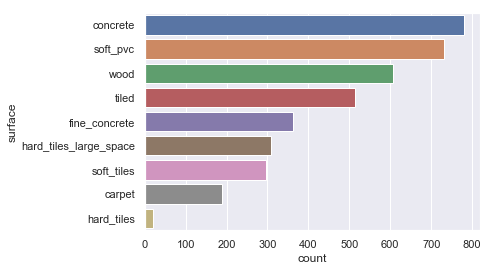

In [15]:
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = target,
              order = target['surface'].value_counts().index)
plt.show()

In [16]:
data.head()

Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')


In [17]:
def feat_eng(data):
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 +
                             data['angular_velocity_Z'])** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 +
                             data['linear_acceleration_Z'])**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 +
                             data['orientation_Z'])**0.5
    #Lets derive one more column since there is a relationship in velocity and acceleration
    # v = u + a*t , u is initial velocty. if u = 0, then v = at means t = v/a
    # but value of acceleration is more and value of velocity is less, lets do a/v relation
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    # Deriving more feature, since we are reducing rows now, we should know min,max,mean values
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df
    

In [18]:
data = feat_eng(data)
test = feat_eng(test)

In [19]:
data.head()
print(data.columns)

,orientation_X_mean,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_abs_min,orientation_X_abs_max,orientation_X_abs_avg,orientation_Y_mean,...,totl_xyz_abs_avg,acc_vs_vel_mean,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_abs_min,acc_vs_vel_abs_max,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75822,-0.75953,0.000363,0.998275,0.000015,0.75822,0.75953,0.758875,-0.634008,...,0.933879,29.978968,228.042411,6.043898,30.330393,37.731015,NaN,6.043898,228.042411,117.043154
1,-0.958606,-0.95837,-0.95896,0.000151,0.999385,0.000023,0.95837,0.95896,0.958665,0.241867,...,1.004474,14.176321,60.797417,3.314465,11.735877,18.343054,NaN,3.314465,60.797417,32.055941
2,-0.512057,-0.50944,-0.51434,0.001377,0.990473,0.000041,0.50944,0.51434,0.511890,-0.846171,...,0.921290,18.434759,62.823610,2.782415,13.314597,22.578809,NaN,2.782415,62.823610,32.803013
3,-0.939169,-0.93884,-0.93968,0.000227,0.999106,0.000026,0.93884,0.93968,0.939260,0.310140,...,1.008547,26.692052,113.910293,1.386540,21.219546,82.154322,NaN,1.386540,113.910293,57.648417
4,-0.891301,-0.88673,-0.89689,0.002955,0.988672,0.000080,0.88673,0.89689,0.891810,0.428144,...,1.018694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Filling missing data by zeroes
data.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.fillna(0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [21]:
#Label Encoding
target['surface'] = le.fit_transform(target['surface'])

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import gc
folds = StratifiedKFold(n_splits=5, shuffle=True)

Fold: 0 score: 0.8838120104438643
balanced cv score 0.8524281229897841
Fold: 1 score: 0.8823529411764706
balanced cv score 0.829238336339172
Fold: 2 score: 0.884514435695538
balanced cv score 0.8143911890769411
Fold: 3 score: 0.8802631578947369
balanced cv score 0.8080229273254044
Fold: 4 score: 0.8731836195508587
balanced cv score 0.8023518696178832
Avg Accuracy 0.8808252329522936
Avg Balanced Accuracy 0.821286489069837


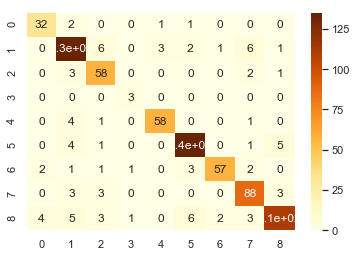

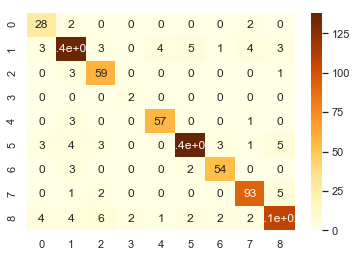

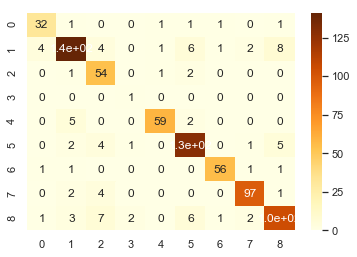

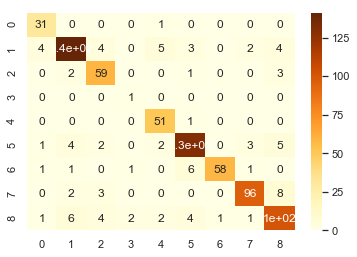

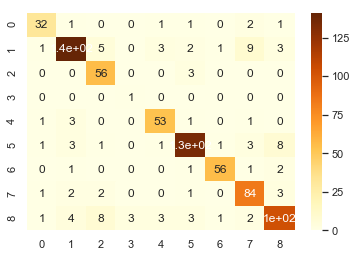

In [23]:
predicted = np.zeros((test.shape[0],9))
# measured= np.zeros((data.shape[0]))
score = 0
balanced_cv_sum = 0
# Balanced model training gives slightly worse results on pubLB.
model = RandomForestClassifier(n_estimators=200)
# model = XGBClassifier(tree_method='gpu_hist')
# model = LGBMClassifier(device='gpu')
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    # measured[val_idx] = model.predict(data.iloc[val_idx])
    # predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))
    cm = confusion_matrix(model.predict(data.iloc[val_idx]), target['surface'].iloc[val_idx])
    plt.figure()
    sns.heatmap(cm, annot=True, cmap="YlOrBr")
    balscore = balanced_cv(cm)
    print('balanced cv score', balscore)
    balanced_cv_sum +=balscore
    gc.collect()
print('Avg Accuracy', score / folds.n_splits)
print('Avg Balanced Accuracy', balanced_cv_sum / folds.n_splits)
    

In [24]:
model.fit(data, target['surface'])
predicted = model.predict_proba(test)
sampl['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sampl.to_csv('submission.csv', index=False)
# sampl.head()

In [25]:
#Robust model
'''
iter_count = 20
robust_predicted = 0
for iteration in range(iter_count):
    rand_tr_set, rand_test_set = train_test_split(test,train_size=0.8)
    robust_predicted += model.predict_proba(rand_tr_set)/iter_count
    
print(robust_predicted)
'''

'\niter_count = 20\nrobust_predicted = 0\nfor iteration in range(iter_count):\n    rand_tr_set, rand_test_set = train_test_split(test,train_size=0.8)\n    robust_predicted += model.predict_proba(rand_tr_set)/iter_count\n    \nprint(robust_predicted)\n'